## 앙상블 

여러 개의 분류기를 생성하고, 그 예측을 결합 함으로써 보다 정확한 예측을 도출하는 기법

* 앙상블 방법은 예측기가 가능한 서로 독립적일 때 최고의 성능을 발휘한다. 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것이다. 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킨다. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

###  투표기반 분류기

In [2]:
# 동전던지기 
heads_proba = 0.51 # 앞면이 나올 확률
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

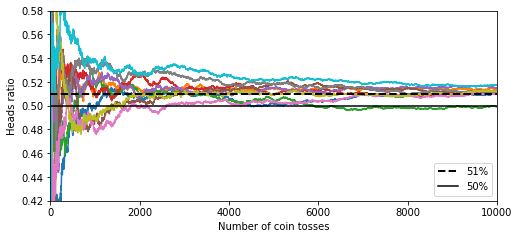

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)


voting_clf = VotingClassifier( estimators = [('lr', log_clf), ('rf',rnd_clf), ('svc',svm_clf)], voting = 'hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf , rnd_clf , svm_clf, voting_clf) :
    clf.fit(X_train ,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__ ,accuracy_score(y_test , y_pred))
    

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


모든 분류기가 클래스의 확률을 예측할 수 있으면 (predict_proba() method가 있으면 ), 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다. 이를 **간접투표**라고 한다. 이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접투표 방식보다 성능이 더 높다. 이 방식을 사용하기 위해서는 voting = 'hard' 를 voting = 'soft'로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 된다. 

In [7]:
# 간접투표 
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


### 배깅과 페이스팅 

알고리즘을 사용하여 훈련세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것이다. 배깅과 페이승에서는 같은 훈련 샘플을 여러개의 예측기에 걸쳐 사용할 수 있다. 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링 할 수 있다. 

* 훈련세트에서 중복을 허용하여 샘플링하는 방식을 배깅(bootstrap aggregating) 
* 훈련세트에서 중복을 허용하지 않고 샘플링하는 방식을 페이스팅



모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다. 수집함수는 전형적으로 분류일 때는 **통계적 최빈값**(직접투표분류기 처럼 가장 많은 예측결과)이고 회귀에 대해서는 평균을 계산한다. 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다. 

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 현재 있는 표본에서 추가적으로 표본을 복원 추출하고 각 표본에 대한 통계량을 다시 계산, bootstrap
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

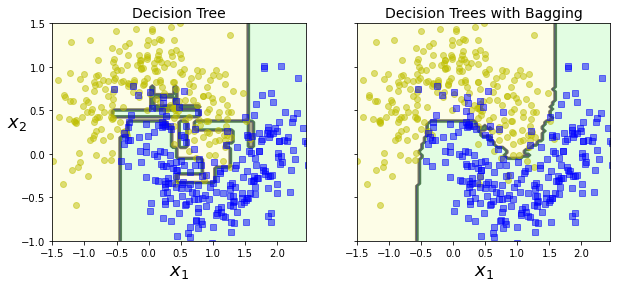

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

boostraping은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다. 하지만 다양성을 추가하는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다. 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호된다. 

### OOB 평가 

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다. BaggingClassifier는 기본값으로 중복을 허용하여 훈련세트의 크기만큼인 m개 샘플을 선택한다. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링 된다는 것을 의미한다. 선택되지 않은 훈련 새플의 나머지 37%를 oob,out of bag 샘플이라고 부른다. 예측기마다 oob는 다름 

예측기가 훈련하는 동안에는 oob샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob샘플을 사용해 평가 할 수 있다. 앙상블의 평가는 각 예측기의 oob평가를 평균하여 얻는다. 

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [16]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

### 랜덤패치와 랜덤 서브스페이스 

BaggingClassifier는 특성 샘플링도 지원한다. 샘플링는 max_features, bootstrap_features 두 매개변수로 조절된다. 작동방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링이다. 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다. 
이 기업은 특히 이미지와 같은 매우 고차원의 데이터셋을 다룰 때 유용하다. 

**훈련샘플과 샘플을 모두 샘플링하는 것은 랜덤패치방식이라고 한다.** 훈련샘플을 모두 사용하고 (boostrap = False 이고 max_samples = 1.0) 특성은 샘플링하는 (bootstrap_feature = True 그리고/또는 max_features는 1.0보다 작게 설정)것을 랜덤 서브스페이스 방식이라고 한다. 

#### 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다. 

## 랜덤 포레스트 

랜덤 포레스트는 일반적으로 배깅 또는 페이스팅을 적용한 결정트리 앙상블 방법이다.  전형적으로 max_samples를 훈련세트의 크기로 지정한다. BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있다. 

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트는 몇가지 예외가 있지만 결정트리의 매개변수와 앙상블 자체를 제어하는데 필요한 BaggingClassifier의 매개변수를 모두 갖고 있다.

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다. 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어 준다. 

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [20]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

1.0

## 엑스트라 트리 

랜덤 포레스트에서 트리를 만들때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용한다. 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택한다. 

극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤트리 앙상블, 엑스트라트리**라고 한다. 편향이 늘어나지만 대신 분산을 낮추게 된다. 
모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트 보다 엑스트라 트리가 더 작업 속도가 빠르다.



In [26]:
from sklearn.ensemble import ExtraTreesClassifier

Et_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
Et_clf.fit(X_train, y_train)

y_pred_Et = rnd_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_Et))
print(accuracy_score(y_test, y_pred_rf))

0.912
0.912


## 특성 중요도 

랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다. 사이킷 런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시ㅣ는지 확인하여 특성의 중요도르 측정한다. 가중치 평균이며. 각 노드의 가중치는 연관된 훈련 샘플 수와 같다. 

 사이킷런은 훈련이 끝난 뒤 특성마다 작동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화 한다. 이 값은feature_importances_변수에 저장된다. 

In [27]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [28]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

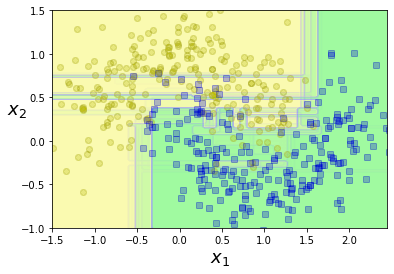

In [29]:
# 15개 결정 트리의 결정 경계를 중첩한 것 , 개별 결정 트리는 불완전하지만 앙상블되면 매우 좋은 결정 경계를 만든다.

plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [30]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [31]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [34]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

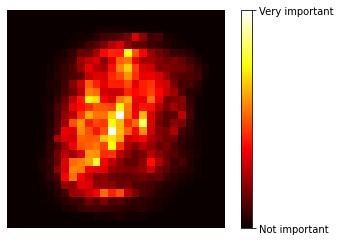

In [35]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## 부스팅 

부스팅은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법을 말한다. 부스팅 방법의 아이디어는 앞의 모델을 보완해 나가면서 일련의 예측기를 학습시키는 것이다. 

## 에이다부스트 

이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이다. 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다. 이것이 에이다부스트에서 사용하는 방식이다. 
<img src="https://formal.hknu.ac.kr/handson-ml2/slides/images/ch07/homl07-08.png" width="500" height="300"/> 




에이다부스트 분류기를 만들 때 알고리즘이 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련 시키고 예측을 만든다. 그 다음 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다. 두번 째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈현하고 다시 예측을 만든다. 그 다음 다시 가중치를 업데이트하는 식으로 계속 진행 된다. 

모든 예측기가 훈련을 마치면 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만든다. 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기 마다 다른 가중치가 적용된다. 

연속된 학습 기법에는 중용한 단점이 있다. 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습될 수 있기 때문에 병렬화 또는 분할을 할 수 없다. 결국 배깅이나 페이스팅만큼 확장성이 높지 않다. 

In [36]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

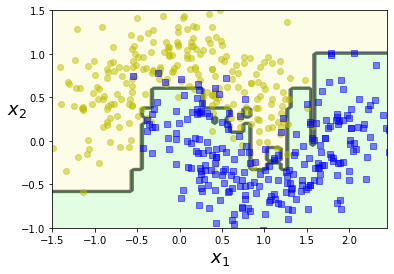

In [37]:
plot_decision_boundary(ada_clf, X, y)

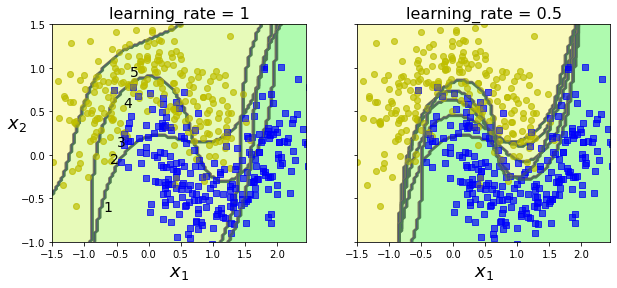

In [38]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

예측을 할 때 에이다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 aj를 더해 예측 결과를 만든다. j는 예측기, 가중치 합이 가장 큰 클새그가 예측 결과가 된다. 

## 그레이디언트 부스팅 

그레이디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다. 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여오차에 새로운 예측기를 학습한다. 


In [39]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [42]:
# 첫번 째 예측기에서 생긴 잔여 오차에 두번째 훈련

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [43]:
# 두번 째 예측기에서 생긴 잔여오차에 세번째 훈련 

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [44]:
X_new = np.array([[0.8]])

In [45]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [46]:
y_pred

array([0.75026781])

In [47]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

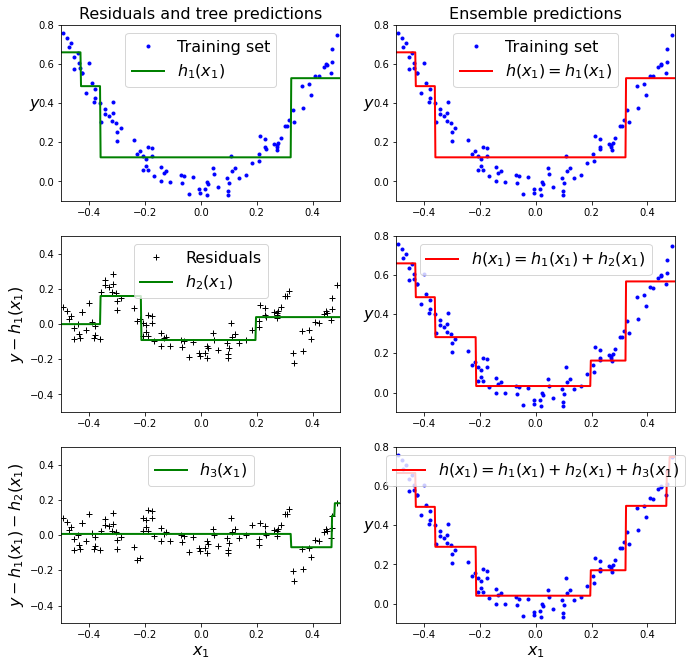

In [48]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [50]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

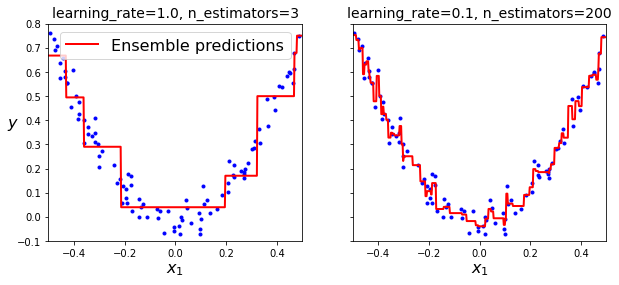

In [51]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

학습률 매개변수가 각 트리의 기여정도를 조절한다. 0.1처럼 낮게 설정하면 앙상블을 훈련세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아진다. 이는 축소 라고 부르는 규제 방법이다. 

최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용할 수 있다. 간단하게 구현하려면 staged_predict()메서드를 사용한다. 이 메서드는 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환한다. 

In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [59]:
np.argmin(errors) 

55

In [53]:
min_error = np.min(errors)

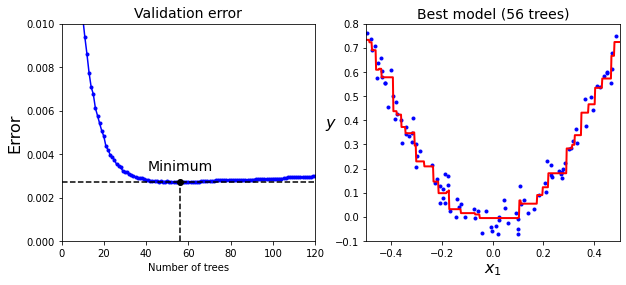

In [54]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

실제로 훈련을 중지하는 방법으로 조기 종료를 구현할 수있다. warm_strart = True로 설정하면 사이키런이 fit()메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있다. 

In [60]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [61]:
print(gbrt.n_estimators)

61


In [62]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원한다. subsample = 0.25라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습된다. 편향이 높아지는 대신 분산이 낮아지게 된다. 또한 훈련속도를 상당히 높인다. 이런 기법은 **확률적 그레이언드 부스팅**이라고 한다.

In [63]:
# 익스트림 그레이언트 부스팅 
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [64]:
if xgboost is not None:  
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)           

Validation MSE: 0.004000408205406276


In [65]:
if xgboost is not None:  
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)            

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


In [66]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

60.8 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [67]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

7.7 ms ± 80.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 스태킹 

앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련 시킬 수 없을까? 라는 아이디어에서 출발 

<img src="https://yganalyst.github.io/assets/images/ML/chap6/stacking1.png" width="300" height="300"/> 

세예측기는 각각 다른값을 예측하고 마지막 예측기(블렌더, 메타 학습기)가 이 예측을 입력으로 받아 최종 예측을 만든다. 



<img src="https://yganalyst.github.io/assets/images/ML/chap6/stacking2.png" width="300" height="300"/> 

블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 이용한다. 먼저 훈련 세트를 두개의 서브셋으로 나눈다. 첫 번째 서브셋은 첫번 째 레이어의 예측을 훈련시키기 위해 사용, 첫번 째 예측기를 사용해 두 번째 세트에 대한 예측을 만든다. 예측기들은 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이 때 만들어진 예측은 완전히 새로운 것이다. 


<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSo_cFOjMtVFY0eYsnNL2sNQmhFrXSFnghKpTcacpq8Kdn0BpUWcoIJiiQKKw7MDC1fJo4&usqp=CAU" width="300" height="300"/> 
홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있다. 타깃값은 그대도 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련세트를 만들 수 있다. 블렌더가 새 훈련 세트로 훈련된다. 즉 첫 번째 레이어의 예측을 갖고 타깃값을 예측하도록 학습한다.